In [21]:
import pandas as pd
import pylab
import numpy as np
import sklearn
from sklearn import linear_model
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from statsmodels.stats import proportion

# Load the UCI adult dataset 

 Download the data for this notebook from Source: https://archive.ics.uci.edu/ml/datasets/Adult

In [22]:
# Source: https://www.valentinmihov.com/2015/04/17/adult-income-data-set/

features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"] 


train_url = '~/Documents/Teaching/490/data/adult.data'
test_url = '~/Documents/Teaching/490/data/adult.test'

original_train = pd.read_csv(train_url, names=features, sep=r'\s*,\s*', 
                             engine='python', na_values="?")
original_test = pd.read_csv(test_url, names=features, sep=r'\s*,\s*', 
                            engine='python', na_values="?", skiprows=1)

num_train = len(original_train)
print('Number of training points')
print(num_train)


print('Number of testing points')
print(len(original_test))


original = pd.concat([original_train, original_test])

original.head()



Number of training points
32561
Number of testing points
16281


,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Descriptive Analysis

    Let's take a deeper dive to our data. We want to precit income so let's see how it is distributed.

In [23]:
original_less50K = len(original[(original.Target == '<=50K') | (original.Target == '<=50K.')])/len(original)
original_less50K

#do this for yourself on >50k

0.7607182343065395

In [24]:
#HERE
black = original[original['Race']=='Black'] #subgrouping
white = original[original['Race']=='White']
total_black = len(original[original['Race']=='Black'])
total_white = len(original[original['Race']=='White'])

print(total_black)
print(total_white)


black_less50K = len(black[(black.Target == '<=50K') | (black.Target == '<=50K.')])/total_black
black_greater50K = len(black[(black.Target == '>50K') | (black.Target == '>50K.')])/total_black
white_less50K = len(white[(white.Target == '<=50K') | (white.Target == '<=50K.')])/total_white
white_greater50K = len(white[(white.Target == '>50K') | (white.Target == '>50K.')])/total_white

target_percent = pd.DataFrame({'<=50K': [black_less50K, white_less50K], '>50K': [black_greater50K, white_greater50K]}, index=['Black', 'White'])
target_percent

4685
41762


,<=50K,>50K
Black,0.879189,0.120811
White,0.746013,0.253987


In [25]:
female = original[original['Sex']=='Female'] #subgrouping
male = original[original['Sex']=='Male']
total_female=len(female)
total_male=len(male)
print(total_female)
female_less50K = len(female[(female.Target == '<=50K') | (female.Target == '<=50K.')])/total_female
female_greater50K = len(female[(female.Target == '>50K') | (female.Target == '>50K.')])/total_female
male_less50K = len(male[(male.Target == '<=50K') | (male.Target == '<=50K.')])/total_male
male_greater50K = len(male[(male.Target == '>50K') | (male.Target == '>50K.')])/total_male

target_percent = pd.DataFrame({'<=50K': [female_less50K, male_less50K], '>50K': [female_greater50K, male_greater50K]}, index=['Female', 'Male'])
target_percent


16192


,<=50K,>50K
Female,0.890749,0.109251
Male,0.696233,0.303767


# Check-in point  Build a similar table for gender- Submit it on canvas by end of today. 

# Logistic Regression 

We are going to process our data to make it ready for logistic regression. Unlike linear regression logistic regression uses categorical data. Some important assumptions  of the logistic regression is: 

Logistic Regression Assumptions

    -Binary logistic regression requires the dependent variable to be binary.


    -For a binary regression, the factor level 1 of the dependent variable should represent the desired outcome.


    -Only the meaningful variables should be included.



    -The independent variables should be independent of each other.
    That is, the model should have little or no multicollinearity.



    -The independent variables are linearly related to the log odds.



    -Logistic regression requires quite large sample sizes.


![alt text](a.png)

## Cleaning the data 

Let's first prepare our data such that our target variable is 0 or 1.
By normalizing it and then putting it back into the test and train sets again.
We do this by defining a data_transform function

In [26]:
original.head()
labels = original['Target']
labels = labels.replace('<=50K', 0).replace('>50K', 1)
labels = labels.replace('<=50K.', 0).replace('>50K.', 1)
print(labels)

0        0
1        0
2        0
3        0
4        0
        ..
16276    0
16277    0
16278    0
16279    0
16280    1
Name: Target, Length: 48842, dtype: int64


In [27]:
# Redundant column
del original["Education"]

# Remove target variable
del original["Target"]

def data_transform(df):
    """Normalize features."""
    binary_data = pd.get_dummies(df)
    feature_cols = binary_data[binary_data.columns[:-2]]
    scaler = preprocessing.StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(feature_cols), columns=feature_cols.columns)
    return data

data = data_transform(original)


train_data = data[:num_train]
train_labels = labels[:num_train]



test_data = data[num_train:]
test_labels = labels[num_train:]

data.head()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Never-worked,Workclass_Private,...,Country_Philippines,Country_Poland,Country_Portugal,Country_Puerto-Rico,Country_Scotland,Country_South,Country_Taiwan,Country_Thailand,Country_Trinadad&Tobago,Country_United-States
0,0.025996,-1.061979,1.136512,0.146932,-0.217127,-0.034087,-0.173795,-0.26194,-0.01431,-1.506680,...,-0.077952,-0.042243,-0.037063,-0.061494,-0.02074,-0.048581,-0.036505,-0.024791,-0.023518,0.338083
1,0.828308,-1.007104,1.136512,-0.144804,-0.217127,-2.213032,-0.173795,-0.26194,-0.01431,-1.506680,...,-0.077952,-0.042243,-0.037063,-0.061494,-0.02074,-0.048581,-0.036505,-0.024791,-0.023518,0.338083
2,-0.046942,0.246034,-0.419335,-0.144804,-0.217127,-0.034087,-0.173795,-0.26194,-0.01431,0.663711,...,-0.077952,-0.042243,-0.037063,-0.061494,-0.02074,-0.048581,-0.036505,-0.024791,-0.023518,0.338083
3,1.047121,0.426663,-1.197259,-0.144804,-0.217127,-0.034087,-0.173795,-0.26194,-0.01431,0.663711,...,-0.077952,-0.042243,-0.037063,-0.061494,-0.02074,-0.048581,-0.036505,-0.024791,-0.023518,0.338083
4,-0.776316,1.408530,1.136512,-0.144804,-0.217127,-0.034087,-0.173795,-0.26194,-0.01431,0.663711,...,-0.077952,-0.042243,-0.037063,-0.061494,-0.02074,-0.048581,-0.036505,-0.024791,-0.023518,-2.957854


In [28]:
cls = linear_model.LogisticRegression()
cls.fit(train_data, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
predictions = cls.predict(test_data)

overall_scores = cls.score(test_data,test_labels)

overall_scores

0.8527117498925127

# Fairness examination 

![alt text](b.png)

# Independece 

Fairness through independence: 

Dempgraphic Parity (group parity): P{C=1,A=a}= P{C=1,A=b}
In this case for example: P{prediction=1, Male} = P{prediction=1,Female}

We can apply some relaxation and say 
P{prediction=1, Male}/ P{prediction=1,Female} >= 1- epsilon

epsilon is usually put to 0.2 

Note what we are calculting is independent of the truth. We just wanna make sure our classifer is equaly accepting 
female and male 

In [30]:
scores = cls.predict_proba(test_data)[:, 1]
d = {'target' : test_labels.values,
     'score' : scores,
     'prediction' : predictions,
     'race' : original_test['Race'],
     'gender' : original_test['Sex']}

marginals = pd.DataFrame(data=d, columns=['target', 'score', 'prediction', 'race', 'gender'])
marginals.head()

,target,score,prediction,race,gender
0,0,0.002752,0,Black,Male
1,0,0.117700,0,White,Male
2,1,0.456652,0,White,Male
3,1,0.754372,1,Black,Male
4,0,0.001220,0,White,Female


In [31]:
postive_class= marginals[(marginals['prediction'] == 1) ]

postive_female= postive_class[(postive_class['gender'] == 'Female')]
postive_male= postive_class[(postive_class['gender'] == 'Male')]


#print(len(postive_female)/len(postive_male))


male = marginals[marginals['gender'] == 'Male']
female = marginals[marginals['gender'] == 'Female']

#print(len(postive_female)/len(female))

#print(len(postive_male)/len(male))

print((len(postive_female)/len(female))/(len(postive_male)/len(male)))





0.30133308247315777


In [41]:
postive_female= postive_class[(postive_class['race'] == 'Black')]
postive_male= postive_class[(postive_class['race'] == 'White')]


#print(len(postive_female)/len(postive_male))


male = marginals[marginals['race'] == 'White']
female = marginals[marginals['race'] == 'Black']

#print(len(postive_female)/len(female))

#print(len(postive_male)/len(male))

print((len(postive_female)/len(female))/(len(postive_male)/len(male)))



0.40888651591419023


# Check-in point

 Calculate the demographic parity for race and do the checkin quiz in canvas. 
 
 Let's look at why it's not fair: for it to be fair ratio>1-epsilon 
 P{R=1∣A=b}/ P{R=1∣A=a} > 1 - epsilon
 

# Seperation 

Separation criteria requires that all groups experience the same false negative rate and the same false positive rate. 


![alt text](c.png)

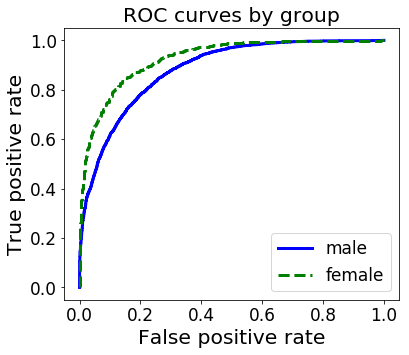

In [33]:
male = marginals[marginals['gender'] == 'Male']
#the metrics.roc_curve method from sklearn library takes the labels, and scores 
# and reutrn false positive, true positive rate and a threshold which we ignore 

fpr_male, tpr_male, _ = metrics.roc_curve(male['target'], male['score'])


female = marginals[marginals['gender'] == 'Female']
fpr_female, tpr_female, _ = metrics.roc_curve(female['target'], female['score'])


plt.figure(1, figsize=(6, 5))
plt.title('ROC curves by group')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.plot(fpr_male, tpr_male, label='male', linestyle='-', color='b')
plt.plot(fpr_female, tpr_female, label='female', linestyle='--', color='g')

plt.legend()
plt.show()

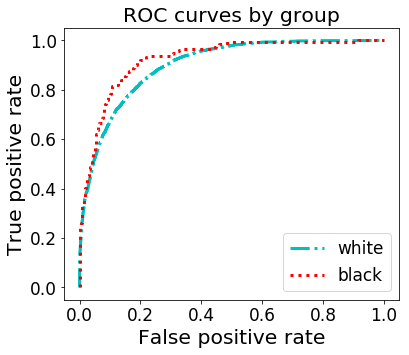

In [34]:
white = marginals[marginals['race'] == 'White']
fpr_white, tpr_white, _ = metrics.roc_curve(white['target'], white['score'])
black = marginals[marginals['race'] == 'Black']
fpr_black, tpr_black, _ = metrics.roc_curve(black['target'], black['score'])

plt.figure(1, figsize=(6, 5))
plt.title('ROC curves by group')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot(fpr_white, tpr_white, label='white', linestyle='-.', color='c')
plt.plot(fpr_black, tpr_black, label='black', linestyle=':', color='r')
plt.legend()
plt.show()

# Checkin point 

What observation can you make from the above ROC curve?

# Relaxation of separation 


Predictive Equality. 
In short, the probability for unqualified individuals to be classified for the
favourable outcome needs to be equal in both groups. We compare the false positive rate (FPR)
This formalises to
P1(Yˆ =1|Y =0)=P0(Yˆ =1|Y =0).

Equality of Opportunity.
The notion of equality of opportunity complements predictive equality.
Instead of expecting equal FPRs, equal false negative rates (FNR) are required. This means, the probability for qualified individuals to be classified for the unfavourable outcome has to be equal in both groups:

P1(Yˆ =0|Y =1)=P0(Yˆ =0|Y =1).

# Sufficiency : 

Marginal table
Let's create a marginal table of the attributes we're interested in: target, score, prediction, race, gender.

In [35]:
def score_range(p, q, df):
    """Returns number of success and observations for given bucket."""
    gp = df[df['score'] > p]
    lq = gp[gp['score'] <= q]
    return [sum(lq['target']), len(lq['target'])]

def get_frequencies(marginals, num_buckets=10):
    """Returns list of lists. The first list is successes 
    for all buckets, the second one is total counts."""
    ts = np.linspace(0, 1, num_buckets+1)
    frequencies = [[],[]]
    for i in range(num_buckets):
        b = score_range(ts[i], ts[i+1], marginals)
        frequencies[0].append(b[0])
        frequencies[1].append(b[1])
    return frequencies

def plot_confidence(plt, xs, n_succs, n_obss, label, linestyle, color, confidence=0.95):
    """Plot a graph with confidence intervals where
       each x corresponds to a binomial random variable in which n_obs observations led to n_succ successes"""
    n_succs, n_obss = np.array(n_succs), np.array(n_obss)
    conf_lbs, conf_ubs = proportion.proportion_confint(n_succs, n_obss, alpha=1-confidence)
    pylab.fill_between(xs, conf_ubs, conf_lbs, alpha=.2, color=color)
    pylab.plot(xs, n_succs / n_obss, '.-', label=label, linestyle=linestyle, color=color)

### Callibration by group 

In [36]:
races = ['White', 'Black']
styles = ['-', '--']
colors = ['g', 'b']
deciles = range(1, 10+1)
pylab.rc('font',  size='17')
pylab.rc('axes', labelsize='large')
pylab.rc('lines', linewidth=3)

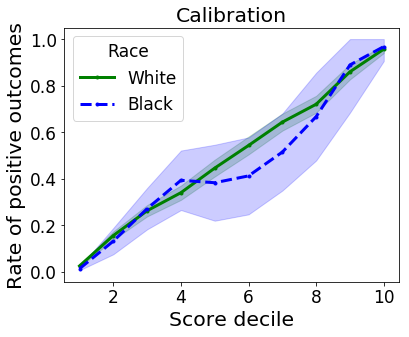

In [37]:
pylab.figure(1, figsize=(6, 5))
pylab.title('Calibration')

for i in range(2):
    race = races[i]
    num = get_frequencies(marginals[marginals['race']== race])
    plot_confidence(plt, deciles, num[0], num[1], race, styles[i], colors[i])

pylab.legend(title="Race")
pylab.ylabel('Rate of positive outcomes')
pylab.xlabel('Score decile')
pylab.tight_layout()

### Callibration by race

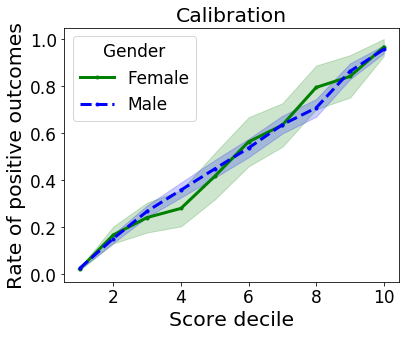

In [38]:
genders = ['Female', 'Male']
pylab.figure(2, figsize=(6, 5))
pylab.title('Calibration')

for i in range(2):
    gender = genders[i]
    num = get_frequencies(marginals[marginals['gender']== gender])
    plot_confidence(plt, deciles, num[0], num[1], gender, styles[i], colors[i])
    
plt.legend(title="Gender")
pylab.ylabel('Rate of positive outcomes')
pylab.xlabel('Score decile')
pylab.tight_layout()
pylab.show()
pylab.close()

### ROC Curve

In [39]:
#tmp.head()

In [40]:
tmp['Target'].unique()
roc_original=tmp

NameError: name 'tmp' is not defined

### Group by race

In [ ]:
total_black = len(roc_original[roc_original['Race']=='Black'])
total_white = len(roc_original[roc_original['Race']=='White'])
total_male = len(roc_original[roc_original['Sex']=='Male'])
total_female = len(roc_original[roc_original['Sex']=='Female'])
black = roc_original[roc_original['Race']=='Black']
white = roc_original[roc_original['Race']=='White']
male = roc_original[roc_original['Sex']=='Male']
female = roc_original[roc_original['Sex']=='Female']

# Race

black_less50K = len(black[(black.Target == '<=50K') | (black.Target == '<=50K.')])/total_black
black_greater50K = len(black[(black.Target == '>50K') | (black.Target == '>50K.')])/total_black
white_less50K = len(white[(white.Target == '<=50K') | (white.Target == '<=50K.')])/total_white
white_greater50K = len(white[(white.Target == '>50K') | (white.Target == '>50K.')])/total_white

target_percent = pd.DataFrame({'<=50K': [black_less50K, white_less50K], '>50K': [black_greater50K, white_greater50K]}, index=['Black', 'White'])
target_percent

### Group by Gender